In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms


# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256),#, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        #transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standard
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [2]:
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
import numpy as np
batch_size = 128
# Datasets from folders
train_dataset = datasets.ImageFolder(root='Images', transform=image_transforms['train'])
valid_dataset = datasets.ImageFolder(root='Images', transform=image_transforms['valid'])

total_len = len(train_dataset)
train_size = 0.8
indices = list(range(total_len))
np.random.shuffle(indices)
# Dataloader iterators, make sure to shuffle
train_data = Subset(train_dataset,indices=indices[:int(np.floor(train_size*total_len))])
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_data = Subset(valid_dataset ,indices=indices[int(np.floor((train_size-1)*total_len)):])
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'n02093256-Staffordshire_bullterrier')

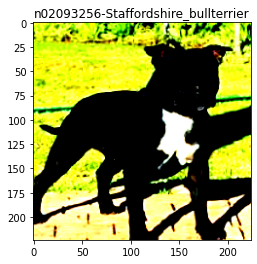

In [3]:
import matplotlib.pyplot as plt
import numpy as np
images, labels = next(iter(valid_dataloader)) 
im = images[0].numpy().transpose((1,2,0))
plt.imshow(im)
plt.title(valid_dataset.classes[labels[0]])


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = torchvision.models.resnet50(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

cuda:0


In [5]:
print(model)
model.fc = nn.Linear(in_features=2048, out_features=120,bias=True)
model = model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [7]:
from tqdm import tqdm

n_epochs = 5

for epoch in tqdm(range(n_epochs)):
    train_loss = []
    for data_t, targets_t in train_dataloader:
        data_t = data_t.to(device)
        targets_t = targets_t.to(device)
        optimizer.zero_grad()
        # Generate predictions
        out = model(data_t)
        # Calculate loss
        loss = criterion(out, targets_t)
        train_loss.append(loss.item())
        # Backpropagation
        loss.backward()
        # Update model parameters
        optimizer.step()
    print("Loss: ",np.average(train_loss))

100%|██████████| 5/5 [07:54<00:00, 94.86s/it]Loss:  2.914059214998585



In [10]:
val_loss = []
val_acc = []
batch_loss = 0
correct_t = 0
total_t = 0
with torch.no_grad():
        model.eval()
        for data_t, target_t in (valid_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            out = model(data_t)
            loss = criterion(out, target_t)

            _,pred_t = torch.max(out, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(loss.item())
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

validation loss: 1.4615, validation acc: 82.4101

